# <center> Reinforcement Learning - Individual Assignment

---

### <center> Paul Bédier

#### <center> MSc Data Science & Business Analytics, CentraleSupélec

### 0. Instructions

The goal of this assignment is to apply reinforcement learning methods to a
simple game called Text Flappy Bird (TFB). The game is a variation to the
well know Flappy Bird in which the player is made with a simple unit-element
character. 

The environment is already implemented and can be found at the Text
Flappy Bird Gym Gitlab (https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/). Instructions on how to use it can also be
found at the same repository. 

There are two available versions of the environment, one that returns as an observation the complete screen render of the
game (TextFlappyBird-screen-v0) and another one that returns the distance of the player from the center of the closest upcoming pipe gap (TextFlappyBird-v0)
along the two axes (x, y).

Within the scope of this assignment you are asked to implement and compare
two agents that can solve the TextFlappyBird-v0 environment. Feel free to use
any algorithm that is presented in the book of Sutton and Barto.

### 1. Library & Environment Imports 

In [ ]:
!pip install gymnasium
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

In [3]:
# Basics
import os, sys
import time
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import math
import random
import pandas as pd
import pickle

# Gym Environment
import gymnasium as gym
import text_flappy_bird_gym

# Plots
import matplotlib 
import matplotlib.pyplot as plt

In [4]:
# Plot Settings
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

### 2. First Agent: Q-Learning

In order to solve the TextFlappyBird-v0 environment, I will start by implementing, finetuning and testing an agent based on Q-Learning algorithm with $ϵ$-greedy action selection. The algorithm is as follows:
<br><br>

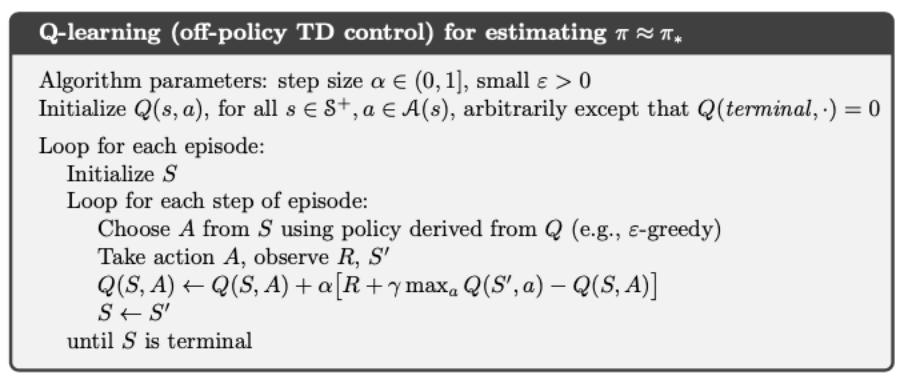

#### a) Agent Class Definition

In [ ]:
# Main Q-Learning Agent Class
class QLearningAgent():

    # Initiatilization
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            eps_decay (float): The decay rate of the epsilon parameter,
            step_size (float): The step-size,
            step_size_decay (float): The decay rate of the step-size parameter,
            discount (float): The discount factor,  
            seed (int): The seed for random number generator 
        }
        """
        # Store the parameters provided in agent_init_info
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.eps_decay = agent_init_info["eps_decay"]
        self.step_size = agent_init_info["step_size"]
        self.step_size_decay = agent_init_info["step_size_decay"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create a dictionary for action-value estimates (better suited than predifined array as we do not know the exact number of states)
        self.q = {}

    # Function to check if state has been visited before (if not, initialize q action-values to 0)
    def is_state_visited(self, state):
      if (state, 0) not in self.q:
            self.q[(state, 0)] = 0
      if (state, 1) not in self.q:
            self.q[(state, 1)] = 0

    # Start method
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        # Check if state has been visited before
        self.is_state_visited(state)

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        self.prev_state = state
        self.prev_action = action

        return action

    # Step method
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        # Check if state has been visited before
        self.is_state_visited(state)

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        # Perform an update
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward + self.discount * np.max(current_q) - self.q[(self.prev_state, self.prev_action)])    

        # Decay for the step-size
        if self.step_size > 0.1:
                self.step_size = max(self.step_size * self.step_size_decay, 0.1) 

        # Decay for the epsilon
        if self.epsilon > 0.0001:
                self.epsilon = max(self.epsilon * self.eps_decay, 0.0001) 
        
        self.prev_state = state
        self.prev_action = action

        return action
    
    # End method
    def agent_end(self, reward, state):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Check if state has been visited before
        self.is_state_visited(state)

        # Perform the last update in the episode
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward - self.q[(self.prev_state, self.prev_action)])             

    # Argmax function
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

#### b) Baseline Runs

100%|██████████| 10000/10000 [00:52<00:00, 191.51it/s]


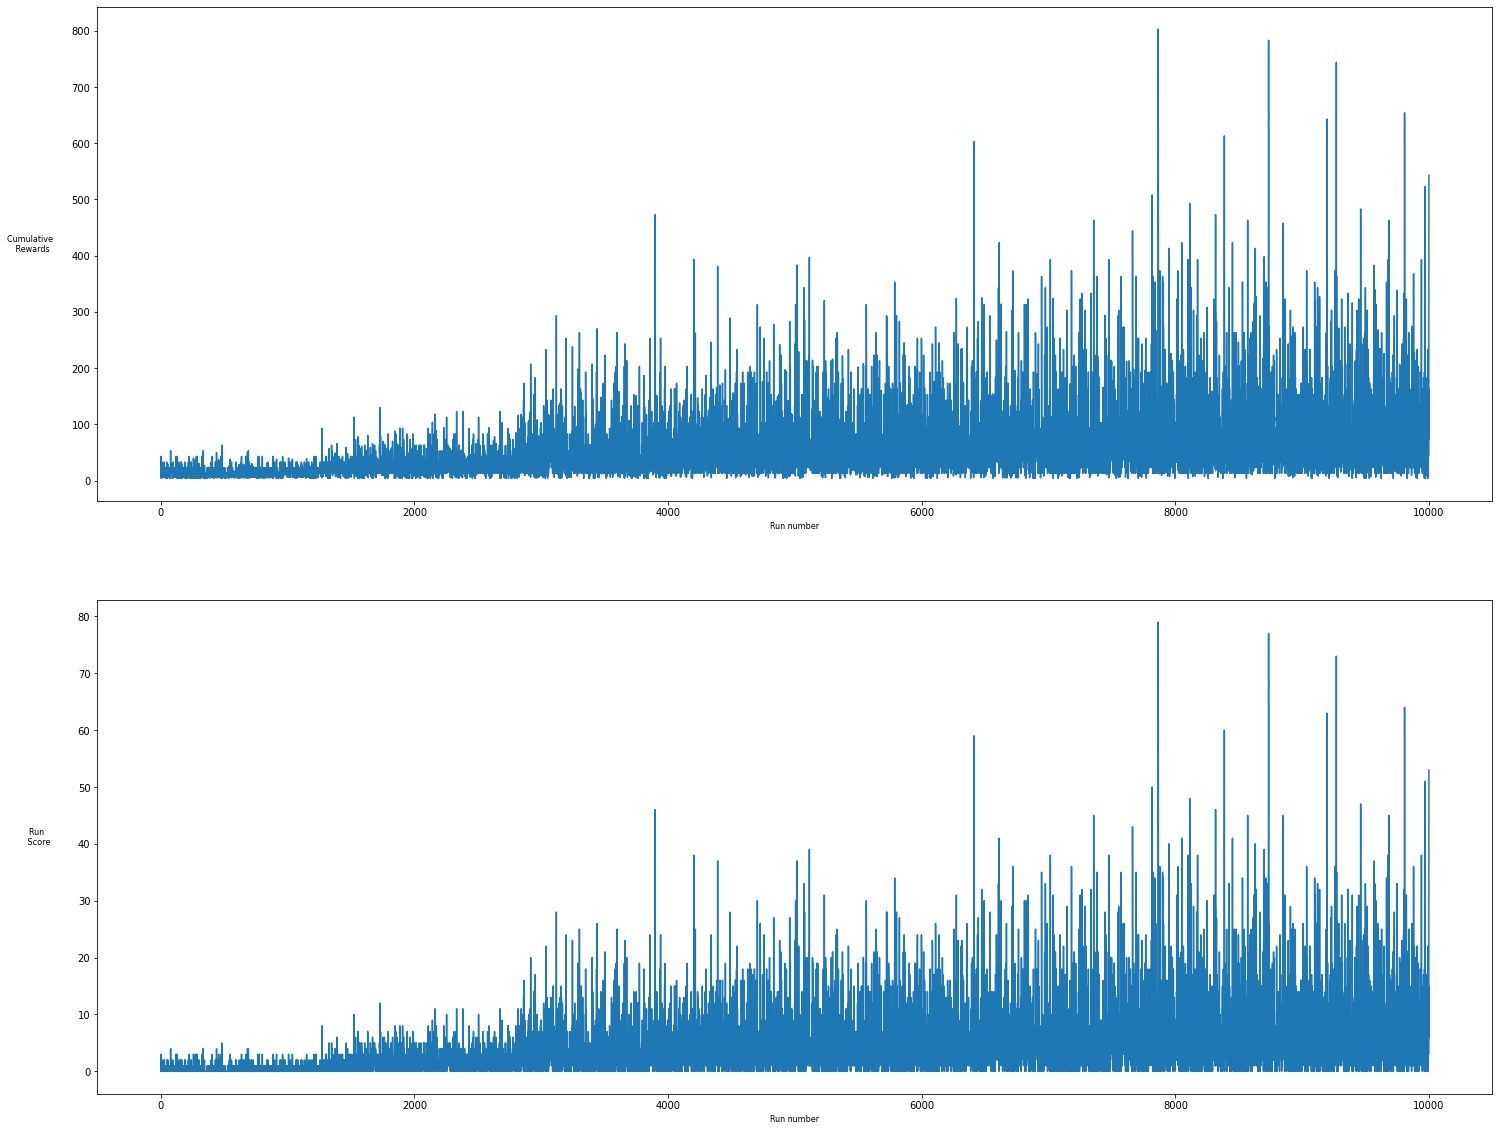

In [ ]:
#  Select agent
agent = QLearningAgent()

# Prepare run results arrays and agent initialization info
total_cumulative_rewards = [] # Cumalative rewards during episode
total_state_visits = [] # State visits counter
run_scores = [] # Run score
agent_info = {"num_actions": 2, "epsilon": 0.1, "eps_decay": 1, "step_size": 0.1, "step_size_decay": 1, "discount": 1, "seed": 42}
agent.agent_init(agent_info)

env_info = {}
num_runs = 10000 # The number of runs
num_episodes = 500 # The number of episodes in each run

# Iteration over the number of runs
for run in tqdm(range(num_runs)):

    # Set the seed value to the current run index x initial seed
    agent_info["seed"] = run*42

    # Initialize the environment
    state = env.reset()

    # Set done to False and 
    done = False

    cumulative_rewards = []
    state_visits = {}

    # Iterate over the number of episodes
    for episode in range(num_episodes):
        if episode == 0:
            # Reset environment and get state
            state, info = env.reset()
            # Start agent
            action = agent.agent_start(state)
            # Initialize state visits counter
            state_visits[state] = 1
            # Take step
            state, reward, done, _, info = env.step(action)
            cumulative_rewards.append(reward)
        else:
            while not done:
              # Select action
              action = agent.agent_step(reward, state)
              # Epsilon decay
              agent.epsilon = agent.epsilon * agent.eps_decay
              # Increment state visits counter
              if state not in state_visits: 
                  state_visits[state] = 1
              else:
                  state_visits[state] += 1
              # Take step
              state, reward, done, _, info = env.step(action)
              cumulative_rewards.append(reward)
              # If terminal state, end agent
              if done:
                action = agent.agent_end(reward, state)
                break

    # Update run results arrays
    total_cumulative_rewards.append(np.sum(cumulative_rewards))
    total_state_visits.append(state_visits)
    run_scores.append(info["score"])

# Plot the results
x = np.arange(num_runs)
plt.figure(figsize=(25, 20))
plt.subplot(211)
plt.plot(x, total_cumulative_rewards)
plt.xlabel("Run number")
plt.ylabel("Cumulative \n Rewards", rotation=0, labelpad=40)
plt.subplot(212)
plt.plot(x, run_scores)
plt.xlabel("Run number")
plt.ylabel("Run \n Score", rotation=0, labelpad=40)
plt.show()

#### c) Hyperparameter Tuning

Step-size Tuning:

In [ ]:
# Running grid search on step_size
labels = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"]
step_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

grid_scores = []
grid_rewards = []

for step_size in tqdm(step_sizes):
    # Prepare run results arrays and agent initialization info
    total_cumulative_rewards = [] # Cumalative rewards during episode
    total_state_visits = [] # State visits counter
    run_scores = [] # Run score
    agent_info = {"num_actions": 2, "epsilon": 0.1, "eps_decay": 1, "step_size": step_size, "step_size_decay": 1, "discount": 1, "seed": 42}
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index x initial seed
        agent_info["seed"] = run*42

        # Initialize the environment
        state = env.reset()

        # Set done to False and 
        done = False

        cumulative_rewards = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
                # Reset environment and get state
                state, info = env.reset()
                # Start agent
                action = agent.agent_start(state)
                # Initialize state visits counter
                state_visits[state] = 1
                # Take step
                state, reward, done, _, info = env.step(action)
                cumulative_rewards.append(reward)
            else:
                while not done:
                  # Select action
                  action = agent.agent_step(reward, state)
                  # Epsilon decay
                  agent.epsilon = agent.epsilon * agent.eps_decay
                  # Increment state visits counter
                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1
                  # Take step
                  state, reward, done, _, info = env.step(action)
                  cumulative_rewards.append(reward)
                  # If terminal state, end agent
                  if done:
                    action = agent.agent_end(reward, state)
                    break

        # Update run results arrays
        total_cumulative_rewards.append(np.sum(cumulative_rewards))
        total_state_visits.append(state_visits)
        run_scores.append(info["score"])

    grid_scores.append(run_scores)
    grid_rewards.append(total_cumulative_rewards)

100%|██████████| 9/9 [09:43<00:00, 64.86s/it]


In [ ]:
# Display results table
score_df = pd.DataFrame()
score_df["Step Size"] = [i for i in labels]
score_df["Mean Score"] = [np.mean(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Median Score"] = [np.median(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Max Score"] = [np.max(grid_scores[i]) for i in range(len(grid_scores))]

reward_df = pd.DataFrame()
reward_df["Step Size"] = [i for i in labels]
reward_df["Mean Reward"] = [np.mean(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Median Reward"] = [np.median(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Max Reward"] = [np.max(grid_rewards[i]) for i in range(len(grid_rewards))]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

Step Size  Mean Score  Median Score  Max Score
      0.1      5.5166           3.0         66
      0.2      7.8874           5.0        120
      0.3      7.7579           5.0         95
      0.4      9.1014           6.0        106
      0.5      8.8044           6.0         90
      0.6      8.5451           5.0        131
      0.7      8.1073           5.0        103
      0.8      7.3633           5.0         81
      0.9      6.9614           4.0         88
Step Size  Mean Reward  Median Reward  Max Reward
      0.1      66.5243           43.0         673
      0.2      90.7321           58.0        1205
      0.3      89.4157           57.0         958
      0.4     102.8258           73.0        1073
      0.5      99.8108           70.0         913
      0.6      97.2277           63.0        1323
      0.7      92.7278           63.0        1043
      0.8      85.2665           57.5         818
      0.9      80.9838           53.0         887


The grid search results seem to indicate that step-size impact on Q-Learning's performance is distributed as a bell shape around 0.4, with highest median and mean score/reward reached for 0.4. Step-size has an impact on convergence speed so we might have gotten other results with a different number of episodes per run.

Epsilon Tuning:

In [ ]:
# Running grid search on epsilon
labels = ["0.001", "0.005", "0.010", "0.015", "0.025", "0.050", "0.100", "0.150", "0.200"]
epsilons = [0.001, 0.005, 0.010, 0.015, 0.025, 0.050, 0.100, 0.150, 0.200]

grid_scores = []
grid_rewards = []

for epsilon in tqdm(epsilons):
    # Prepare run results arrays and agent initialization info
    total_cumulative_rewards = [] # Cumalative rewards during episode
    total_state_visits = [] # State visits counter
    run_scores = [] # Run score
    agent_info = {"num_actions": 2, "epsilon": epsilon, "eps_decay": 1, "step_size": 0.4, "step_size_decay": 1, "discount": 1, "seed": 42}
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index x initial seed
        agent_info["seed"] = run*42

        # Initialize the environment
        state = env.reset()

        # Set done to False and 
        done = False

        cumulative_rewards = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
                # Reset environment and get state
                state, info = env.reset()
                # Start agent
                action = agent.agent_start(state)
                # Initialize state visits counter
                state_visits[state] = 1
                # Take step
                state, reward, done, _, info = env.step(action)
                cumulative_rewards.append(reward)
            else:
                while not done:
                  # Select action
                  action = agent.agent_step(reward, state)
                  # Epsilon decay
                  agent.epsilon = agent.epsilon * agent.eps_decay
                  # Increment state visits counter
                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1
                  # Take step
                  state, reward, done, _, info = env.step(action)
                  cumulative_rewards.append(reward)
                  # If terminal state, end agent
                  if done:
                    action = agent.agent_end(reward, state)
                    break

        # Update run results arrays
        total_cumulative_rewards.append(np.sum(cumulative_rewards))
        total_state_visits.append(state_visits)
        run_scores.append(info["score"])

    grid_scores.append(run_scores)
    grid_rewards.append(total_cumulative_rewards)

100%|██████████| 9/9 [14:40<00:00, 97.83s/it]


In [ ]:
# Display results table
score_df = pd.DataFrame()
score_df["Epsilon"] = [i for i in labels]
score_df["Mean Score"] = [np.mean(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Median Score"] = [np.median(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Max Score"] = [np.max(grid_scores[i]) for i in range(len(grid_scores))]

reward_df = pd.DataFrame()
reward_df["Epsilon"] = [i for i in labels]
reward_df["Mean Reward"] = [np.mean(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Median Reward"] = [np.median(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Max Reward"] = [np.max(grid_rewards[i]) for i in range(len(grid_rewards))]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

Epsilon  Mean Score  Median Score  Max Score
  0.001      0.2694           0.0          6
  0.005     12.2717           4.0        282
  0.010      7.6793           1.0        193
  0.015     18.3764           2.0        440
  0.025     22.5693          10.0        586
  0.050     16.8913          11.0        205
  0.100      8.3263           5.0         95
  0.150      5.4106           3.0         57
  0.200      4.0209           2.0         46
Epsilon  Mean Reward  Median Reward  Max Reward
  0.001      11.6352           10.0          65
  0.005     133.4298           53.0        2833
  0.010      88.5718           23.0        1943
  0.015     195.6333           33.0        4413
  0.025     237.0994          113.0        5873
  0.050     180.9380          120.0        2055
  0.100      95.0476           63.0         963
  0.150      65.8506           43.0         583
  0.200      51.8835           34.0         472


The grid search results seem to indicate that epsilon impact on Q-Learning's performance is peaking for low epsilon values, with highest mean and median score/reward reached for 0.025 and 0.05. A low epsilon value means the agent selects the greedy action most of the time. Let's select 0.025 to help with convergence.

Discount Tuning:

In [ ]:
# Running grid search on discount
labels = ["1", "0.99", "0.95", "0.90", "0.85", "0.80", "0.75", "0.70", "0.65"]
discounts = [1, 0.99, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65]

grid_scores = []
grid_rewards = []

for discount in tqdm(discounts):
    # Prepare run results arrays and agent initialization info
    total_cumulative_rewards = [] # Cumalative rewards during episode
    total_state_visits = [] # State visits counter
    run_scores = [] # Run score
    agent_info = {"num_actions": 2, "epsilon": 0.025, "eps_decay": 1, "step_size": 0.4, "step_size_decay": 1, "discount": discount, "seed": 42}
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index x initial seed
        agent_info["seed"] = run*42

        # Initialize the environment
        state = env.reset()

        # Set done to False and 
        done = False

        cumulative_rewards = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
                # Reset environment and get state
                state, info = env.reset()
                # Start agent
                action = agent.agent_start(state)
                # Initialize state visits counter
                state_visits[state] = 1
                # Take step
                state, reward, done, _, info = env.step(action)
                cumulative_rewards.append(reward)
            else:
                while not done:
                  # Select action
                  action = agent.agent_step(reward, state)
                  # Epsilon decay
                  agent.epsilon = agent.epsilon * agent.eps_decay
                  # Increment state visits counter
                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1
                  # Take step
                  state, reward, done, _, info = env.step(action)
                  cumulative_rewards.append(reward)
                  # If terminal state, end agent
                  if done:
                    action = agent.agent_end(reward, state)
                    break

        # Update run results arrays
        total_cumulative_rewards.append(np.sum(cumulative_rewards))
        total_state_visits.append(state_visits)
        run_scores.append(info["score"])

    grid_scores.append(run_scores)
    grid_rewards.append(total_cumulative_rewards)

100%|██████████| 9/9 [25:04<00:00, 167.14s/it]


In [ ]:
# Display results table
score_df = pd.DataFrame()
score_df["Discount"] = [i for i in labels]
score_df["Mean Score"] = [np.mean(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Median Score"] = [np.median(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Max Score"] = [np.max(grid_scores[i]) for i in range(len(grid_scores))]

reward_df = pd.DataFrame()
reward_df["Discount"] = [i for i in labels]
reward_df["Mean Reward"] = [np.mean(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Median Reward"] = [np.median(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Max Reward"] = [np.max(grid_rewards[i]) for i in range(len(grid_rewards))]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

Discount  Mean Score  Median Score  Max Score
       1     27.1803          15.0        381
    0.99     25.0261          11.0        344
    0.95     25.0783          13.0        356
    0.90     20.2016          10.0        399
    0.85     11.7126           2.0        279
    0.80     19.3859           7.0        481
    0.75     23.8841          11.0        379
    0.70     29.3737          15.0        561
    0.65     20.1128           8.0        382
Discount  Mean Reward  Median Reward  Max Reward
       1     283.6068          163.0        3823
    0.99     261.7187          121.0        3452
    0.95     262.3901          143.0        3568
    0.90     213.8015          108.0        4003
    0.85     129.0955           33.0        2803
    0.80     205.6153           83.0        4823
    0.75     250.7478          115.5        3803
    0.70     305.7283          163.0        5623
    0.65     213.2575           92.0        3831


The grid search results seem to indicate that epsilon impact on Q-Learning's performance is very unequally distributed with two peaks of highest mean and median score/reward reached at 1 and 0.70. A discount of 1 seems safer to ensure a bias towards the long-term objective of staying alive. A discount factor of 1 means the agent values equally present and future rewards.

Step-size Decay Tuning:

In [ ]:
# Running grid search on step-size decay
labels = ["1", "0.99999", "0.9999", "0.999", "0.99", "0.95", "0.90", "0.85"]
step_decays = [1, 0.99999, 0.9999, 0.999, 0.99, 0.95, 0.90, 0.85]

grid_scores = []
grid_rewards = []

for step_decay in tqdm(step_decays):
    # Prepare run results arrays and agent initialization info (higher number of episodes as decay takes time to have an effect)
    total_cumulative_rewards = [] # Cumalative rewards during episode
    total_state_visits = [] # State visits counter
    run_scores = [] # Run score
    agent_info = {"num_actions": 2, "epsilon": 0.025, "eps_decay": 1, "step_size": 0.4, "step_size_decay": step_decay, "discount": 1, "seed": 42}
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 2000 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index x initial seed
        agent_info["seed"] = run*42

        # Initialize the environment
        state = env.reset()

        # Set done to False and 
        done = False

        cumulative_rewards = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
                # Reset environment and get state
                state, info = env.reset()
                # Start agent
                action = agent.agent_start(state)
                # Initialize state visits counter
                state_visits[state] = 1
                # Take step
                state, reward, done, _, info = env.step(action)
                cumulative_rewards.append(reward)
            else:
                while not done:
                  # Select action
                  action = agent.agent_step(reward, state)
                  # Epsilon decay
                  agent.epsilon = agent.epsilon * agent.eps_decay
                  # Increment state visits counter
                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1
                  # Take step
                  state, reward, done, _, info = env.step(action)
                  cumulative_rewards.append(reward)
                  # If terminal state, end agent
                  if done:
                    action = agent.agent_end(reward, state)
                    break

        # Update run results arrays
        total_cumulative_rewards.append(np.sum(cumulative_rewards))
        total_state_visits.append(state_visits)
        run_scores.append(info["score"])

    grid_scores.append(run_scores)
    grid_rewards.append(total_cumulative_rewards)

100%|██████████| 8/8 [09:49<00:00, 73.70s/it]


In [ ]:
# Display results table
score_df = pd.DataFrame()
score_df["Step Size Decay"] = [i for i in labels]
score_df["Mean Score"] = [np.mean(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Median Score"] = [np.median(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Max Score"] = [np.max(grid_scores[i]) for i in range(len(grid_scores))]

reward_df = pd.DataFrame()
reward_df["Step Size Decay"] = [i for i in labels]
reward_df["Mean Reward"] = [np.mean(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Median Reward"] = [np.median(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Max Reward"] = [np.max(grid_rewards[i]) for i in range(len(grid_rewards))]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

Step Size Decay  Mean Score  Median Score  Max Score
              1     24.8281          12.0        457
        0.99999     13.4096           5.0        309
         0.9999      1.4625           0.0         72
          0.999      9.0450           4.0        221
           0.99      8.0359           4.0        148
           0.95      0.2846           0.0          7
           0.90      2.5323           1.0         49
           0.85      3.0261           1.0         64
Step Size Decay  Mean Reward  Median Reward  Max Reward
              1     260.0521          133.0        4583
        0.99999     145.6085           63.0        3103
         0.9999      26.1644           13.0         733
          0.999     100.8116           50.0        2223
           0.99      91.6191           47.0        1493
           0.95      15.2451           13.0          82
           0.90      35.4028           23.0         502
           0.85      42.2591           23.0         653


The grid search results seem to indicate that step-size decay impact on Q-Learning's performance seems detrimental. A step-size decay will however will help convergence.

Epsilon Decay Tuning:


In [ ]:
# Running grid search on epsilon decay
labels = ["1", "0.99999", "0.9999", "0.999", "0.99", "0.95", "0.90", "0.85"]
epsilon_decays = [1, 0.99999, 0.9999, 0.999, 0.99, 0.95, 0.90, 0.85]

grid_scores = []
grid_rewards = []

for epsilon_decay in tqdm(epsilon_decays):
    # Prepare run results arrays and agent initialization info
    total_cumulative_rewards = [] # Cumalative rewards during episode
    total_state_visits = [] # State visits counter
    run_scores = [] # Run score
    agent_info = {"num_actions": 2, "epsilon": 0.025, "eps_decay": epsilon_decay, "step_size": 0.4, "step_size_decay": 0.99, "discount": 1, "seed": 42}
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 2000 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index x initial seed
        agent_info["seed"] = run*42

        # Initialize the environment
        state = env.reset()

        # Set done to False and 
        done = False

        cumulative_rewards = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
                # Reset environment and get state
                state, info = env.reset()
                # Start agent
                action = agent.agent_start(state)
                # Initialize state visits counter
                state_visits[state] = 1
                # Take step
                state, reward, done, _, info = env.step(action)
                cumulative_rewards.append(reward)
            else:
                while not done:
                  # Select action
                  action = agent.agent_step(reward, state)
                  # Epsilon decay
                  agent.epsilon = agent.epsilon * agent.eps_decay
                  # Increment state visits counter
                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1
                  # Take step
                  state, reward, done, _, info = env.step(action)
                  cumulative_rewards.append(reward)
                  # If terminal state, end agent
                  if done:
                    action = agent.agent_end(reward, state)
                    break

        # Update run results arrays
        total_cumulative_rewards.append(np.sum(cumulative_rewards))
        total_state_visits.append(state_visits)
        run_scores.append(info["score"])

    grid_scores.append(run_scores)
    grid_rewards.append(total_cumulative_rewards)

100%|██████████| 8/8 [06:15<00:00, 46.97s/it]


In [ ]:
# Display results table
score_df = pd.DataFrame()
score_df["Epsilon Decay"] = [i for i in labels]
score_df["Mean Score"] = [np.mean(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Median Score"] = [np.median(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Max Score"] = [np.max(grid_scores[i]) for i in range(len(grid_scores))]

reward_df = pd.DataFrame()
reward_df["Epsilon Decay"] = [i for i in labels]
reward_df["Mean Reward"] = [np.mean(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Median Reward"] = [np.median(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Max Reward"] = [np.max(grid_rewards[i]) for i in range(len(grid_rewards))]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

Epsilon Decay  Mean Score  Median Score  Max Score
            1     29.4571          17.0        382
      0.99999      3.6788           3.0         37
       0.9999      0.0004           0.0          1
        0.999      0.2364           0.0          3
         0.99      0.6653           1.0          7
         0.95      0.4422           0.0          3
         0.90      1.0111           1.0          9
         0.85      0.0000           0.0          0
Epsilon Decay  Mean Reward  Median Reward  Max Reward
            1     306.6870          183.0        3833
      0.99999      49.1585           43.0         383
       0.9999      11.6026           13.0          23
        0.999      12.9781           13.0          43
         0.99      15.4884           15.0          81
         0.95      16.0683           13.0          43
         0.90      20.8745           23.0         103
         0.85      11.3726           13.0          13


The grid search results seem to indicate that epsilon decay impact on Q-Learning's performance seems detrimental. An epsilon decay will however help with convergence.

#### d) Final Training

100%|██████████| 100000/100000 [3:53:06<00:00,  7.15it/s]


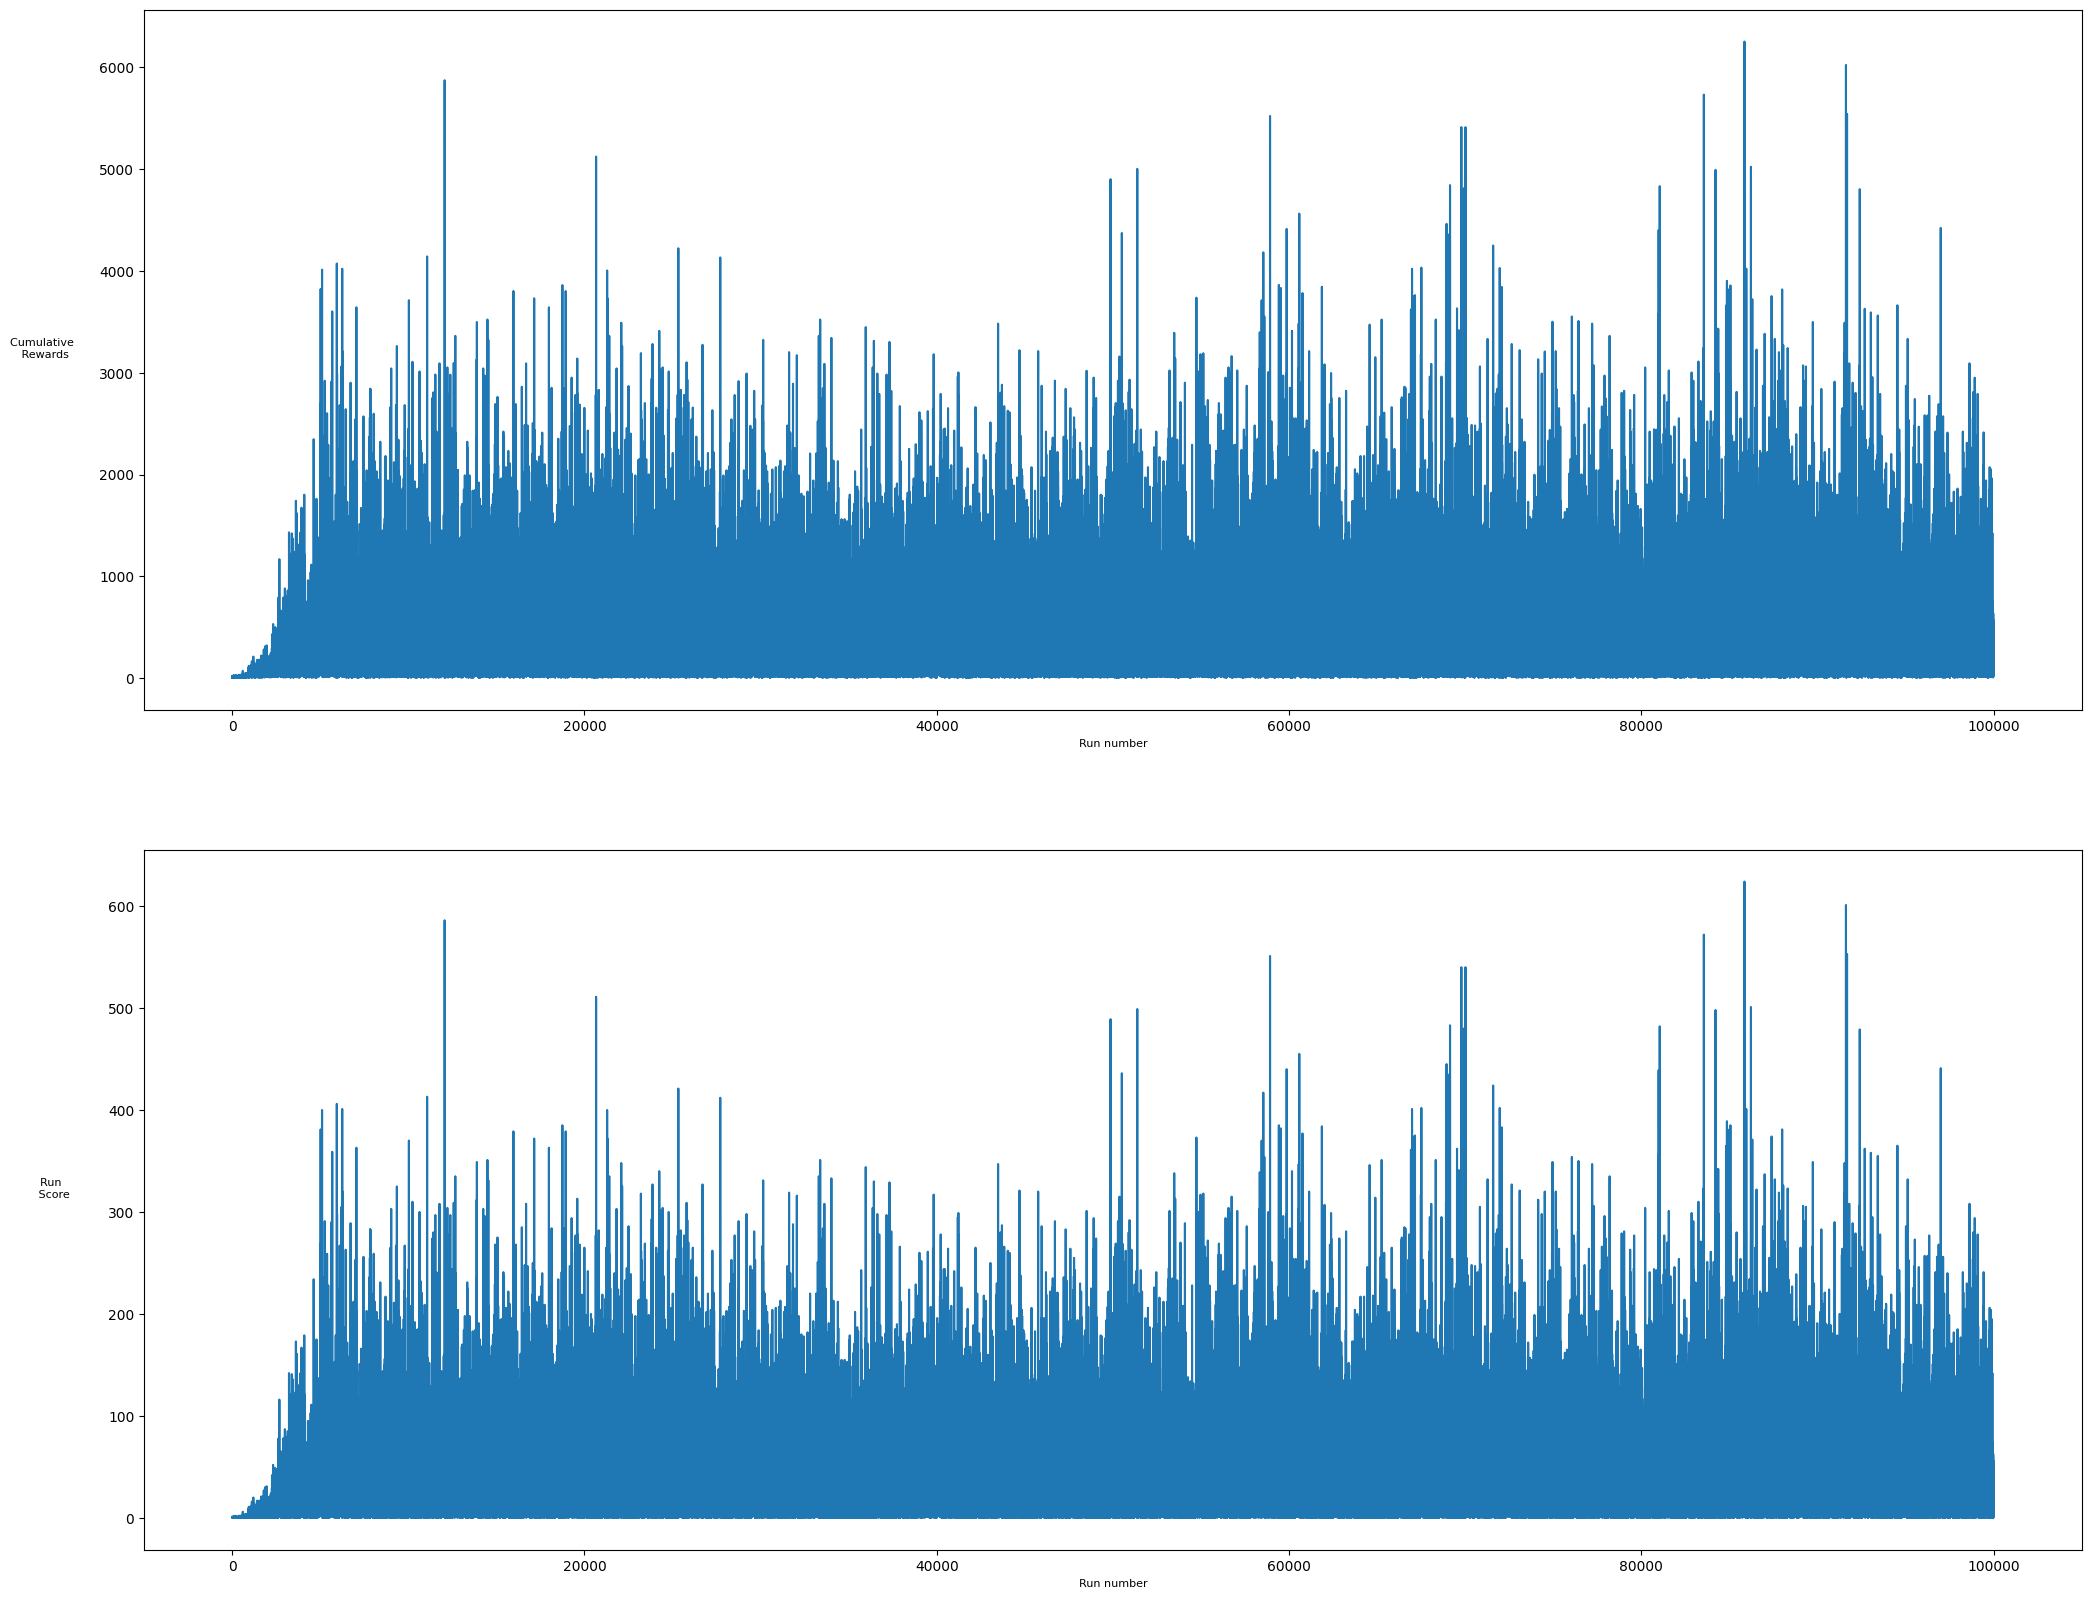

In [ ]:
#  Select agent
agent = QLearningAgent()

# Prepare run results arrays and agent initialization info
total_cumulative_rewards = [] # Cumalative rewards during episode
total_state_visits = [] # State visits counter
run_scores = [] # Run score
agent_info = {"num_actions": 2, "epsilon": 0.025, "eps_decay": 0.99, "step_size": 0.4, "step_size_decay": 0.99, "discount": 1, "seed": 42}
agent.agent_init(agent_info)

env_info = {}
num_runs = 20000 # The number of runs
num_episodes = 1000000 # The number of episodes in each run

# Iteration over the number of runs
for run in tqdm(range(num_runs)):

    # Set the seed value to the current run index x initial seed
    agent_info["seed"] = run*42

    # Initialize the environment
    state = env.reset()

    # Set done to False and 
    done = False

    cumulative_rewards = []
    state_visits = {}

    # Iterate over the number of episodes
    for episode in range(num_episodes):
        if episode == 0:
            # Reset environment and get state
            state, info = env.reset()
            # Start agent
            action = agent.agent_start(state)
            # Initialize state visits counter
            state_visits[state] = 1
            # Take step
            state, reward, done, _, info = env.step(action)
            cumulative_rewards.append(reward)
        else:
            while not done:
              # Select action
              action = agent.agent_step(reward, state)
              # Epsilon decay
              agent.epsilon = agent.epsilon * agent.eps_decay
              # Increment state visits counter
              if state not in state_visits: 
                  state_visits[state] = 1
              else:
                  state_visits[state] += 1
              # Take step
              state, reward, done, _, info = env.step(action)
              cumulative_rewards.append(reward)
              # If terminal state, end agent
              if done:
                action = agent.agent_end(reward, state)
                break

    # Update run results arrays
    total_cumulative_rewards.append(np.sum(cumulative_rewards))
    total_state_visits.append(state_visits)
    run_scores.append(info["score"])

# Plot the results
x = np.arange(num_runs)
plt.figure(figsize=(25, 20))
plt.subplot(211)
plt.plot(x, total_cumulative_rewards)
plt.xlabel("Run number")
plt.ylabel("Cumulative \n Rewards", rotation=0, labelpad=40)
plt.subplot(212)
plt.plot(x, run_scores)
plt.xlabel("Run number")
plt.ylabel("Run \n Score", rotation=0, labelpad=40)
plt.show()

In [ ]:
# Display results table
score_df = pd.DataFrame()
score_df["Mean Score"] = [np.mean(run_scores)]
score_df["Median Score"] = [np.median(run_scores)]
score_df["Max Score"] = [np.max(run_scores)]

reward_df = pd.DataFrame()
reward_df["Mean Reward"] = [np.mean(total_cumulative_rewards)]
reward_df["Median Reward"] = [np.median(total_cumulative_rewards)]
reward_df["Max Reward"] = [np.max(total_cumulative_rewards)]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

 Mean Score  Median Score  Max Score
   42.06877          28.0        624
 Mean Reward  Median Reward  Max Reward
   432.79679          293.0        6253


In [ ]:
# Save Q-Table
with open('QLearning_qtable.pkl', 'wb') as f:
    pickle.dump(agent.q, f)

from google.colab import files
files.download('QLearning_qtable.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### e) Actual Run

In [79]:
# Get Q-value function
def get_qvalue(x, y, q_table):
    # Get the Q-values for all actions in the current state
    zero_state_values = q_table.get(((x, y), 0), {})
    one_state_values = q_table.get(((x, y), 1), {})
    
    if not zero_state_values and not one_state_values:
        # The current state has not been visited yet, return a default value
        return -1
    
    # Find the action with the highest Q-value in the current state 
    if zero_state_values >= one_state_values:
        return 0
    else:
        return 1

In [90]:
# Load Q_table
q_table = pickle.load(open('QLearning_qtable.pkl', 'rb'))

# Prepare run results arrays
total_cumulative_rewards = [] # Cumalative rewards during episode
run_scores = [] # Run score

num_run = 3

for run in tqdm(range(num_run)):

    # Initialize the environment
    state, info = env.reset()
    cumulative_rewards = []

    done = False
    while not done:
        # Select the action with the highest Q-value in the current state
        x, y = state
        action = get_qvalue(x, y, q_table)
        
        if action == -1:
            # The current state has not been visited before, select a random action
            action = env.action_space.sample()
        
        # Take the selected action and observe the next state and reward, add reward to rewards
        state, reward, done, _, info = env.step(action)
        cumulative_rewards.append(reward)
        if info["score"] == 1000000:
            print("\n You are flapping those wings infinitely!!")
            break
    
    total_cumulative_rewards.append(np.sum(cumulative_rewards))
    run_scores.append(info["score"])

# Display results table
print('\n\n')
score_df = pd.DataFrame()
score_df["Mean Score"] = [np.mean(run_scores)]
score_df["Median Score"] = [np.median(run_scores)]
score_df["Max Score"] = [np.max(run_scores)]

reward_df = pd.DataFrame()
reward_df["Mean Reward"] = [np.mean(total_cumulative_rewards)]
reward_df["Median Reward"] = [np.median(total_cumulative_rewards)]
reward_df["Max Reward"] = [np.max(total_cumulative_rewards)]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

 33%|███▎      | 1/3 [02:27<04:55, 147.94s/it]


 You are flapping those wings infinitely!!


 67%|██████▋   | 2/3 [04:43<02:20, 140.59s/it]


 You are flapping those wings infinitely!!


100%|██████████| 3/3 [07:00<00:00, 140.09s/it]


 You are flapping those wings infinitely!!



 Mean Score  Median Score  Max Score
  1000000.0     1000000.0    1000000
 Mean Reward  Median Reward  Max Reward
  10000004.0     10000004.0    10000004


### 3. Second Agent: SARSA

In order to solve the TextFlappyBird-v0 environment, and to try improving on the first agent, I will implement, finetune and test an agent based on SARSA algorithm with $ϵ$-greedy action selection. The algorithm for SARSA is as follows:
<br><br>

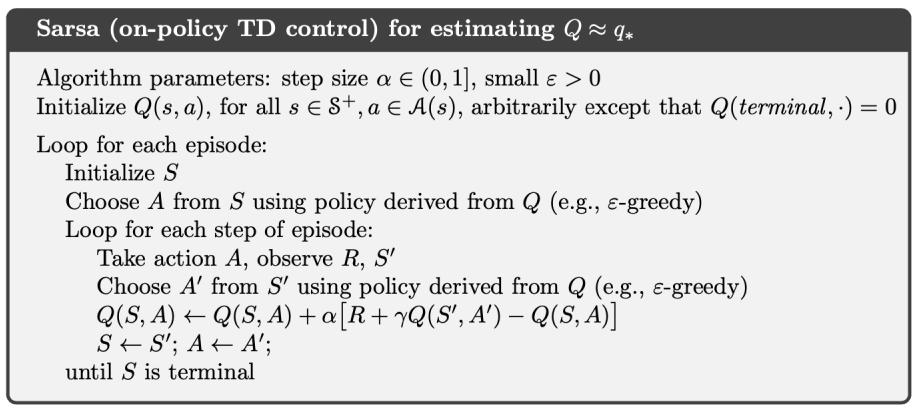

#### a) Agent Class Definition

In [6]:
# Main SARSA Agent Class
class SARSAAgent():
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            eps_decay (float): The decay rate of the epsilon parameter,
            step_size (float): The step-size,
            step_size_decay (float): The decay rate of the step-size parameter,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.eps_decay = agent_init_info["eps_decay"]
        self.step_size = agent_init_info["step_size"]
        self.step_size_decay = agent_init_info["step_size_decay"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])

        # Create a dictionary for action-value estimates (better suited than predifined array as we do not know the exact number of states)
        self.q = {}

    # Function to check if state has been visited before (if not, initialize q action-values to 0)
    def is_state_visited(self, state):
      if (state, 0) not in self.q:
            self.q[(state, 0)] = 0
        
      if (state, 1) not in self.q:
            self.q[(state, 1)] = 0

    # Start method
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Check if the state has already been visited
        self.is_state_visited(state)
        
        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        
        self.prev_state = state
        self.prev_action = action
        
        return action
    
    # Step method
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Check if the state has already been visited
        self.is_state_visited(state)

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]
        
        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        
        # Perform an update
        expected_q = 0
        max_q = np.max(current_q)

        pi = np.ones(self.num_actions) * self.epsilon / self.num_actions + (current_q == max_q) * (1 - self.epsilon) / np.sum(current_q == max_q) # Compute the probability of choosing the greedy action
           
        expected_q = np.sum(current_q * pi)
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward + self.discount * expected_q - self.q[(self.prev_state, self.prev_action)])
        
        # Decay for the step-size
        self.step_size = max(self.step_size * self.step_size_decay, 0.1) 

        # Decay for the epsilon
        self.epsilon = max(self.epsilon * self.eps_decay, 0.0001) 

        self.prev_state = state
        self.prev_action = action

        return action
    
    # End method
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward - self.q[(self.prev_state, self.prev_action)])

    # Argmax function 
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

#### b) Baseline Runs

100%|██████████| 10000/10000 [01:15<00:00, 131.62it/s]


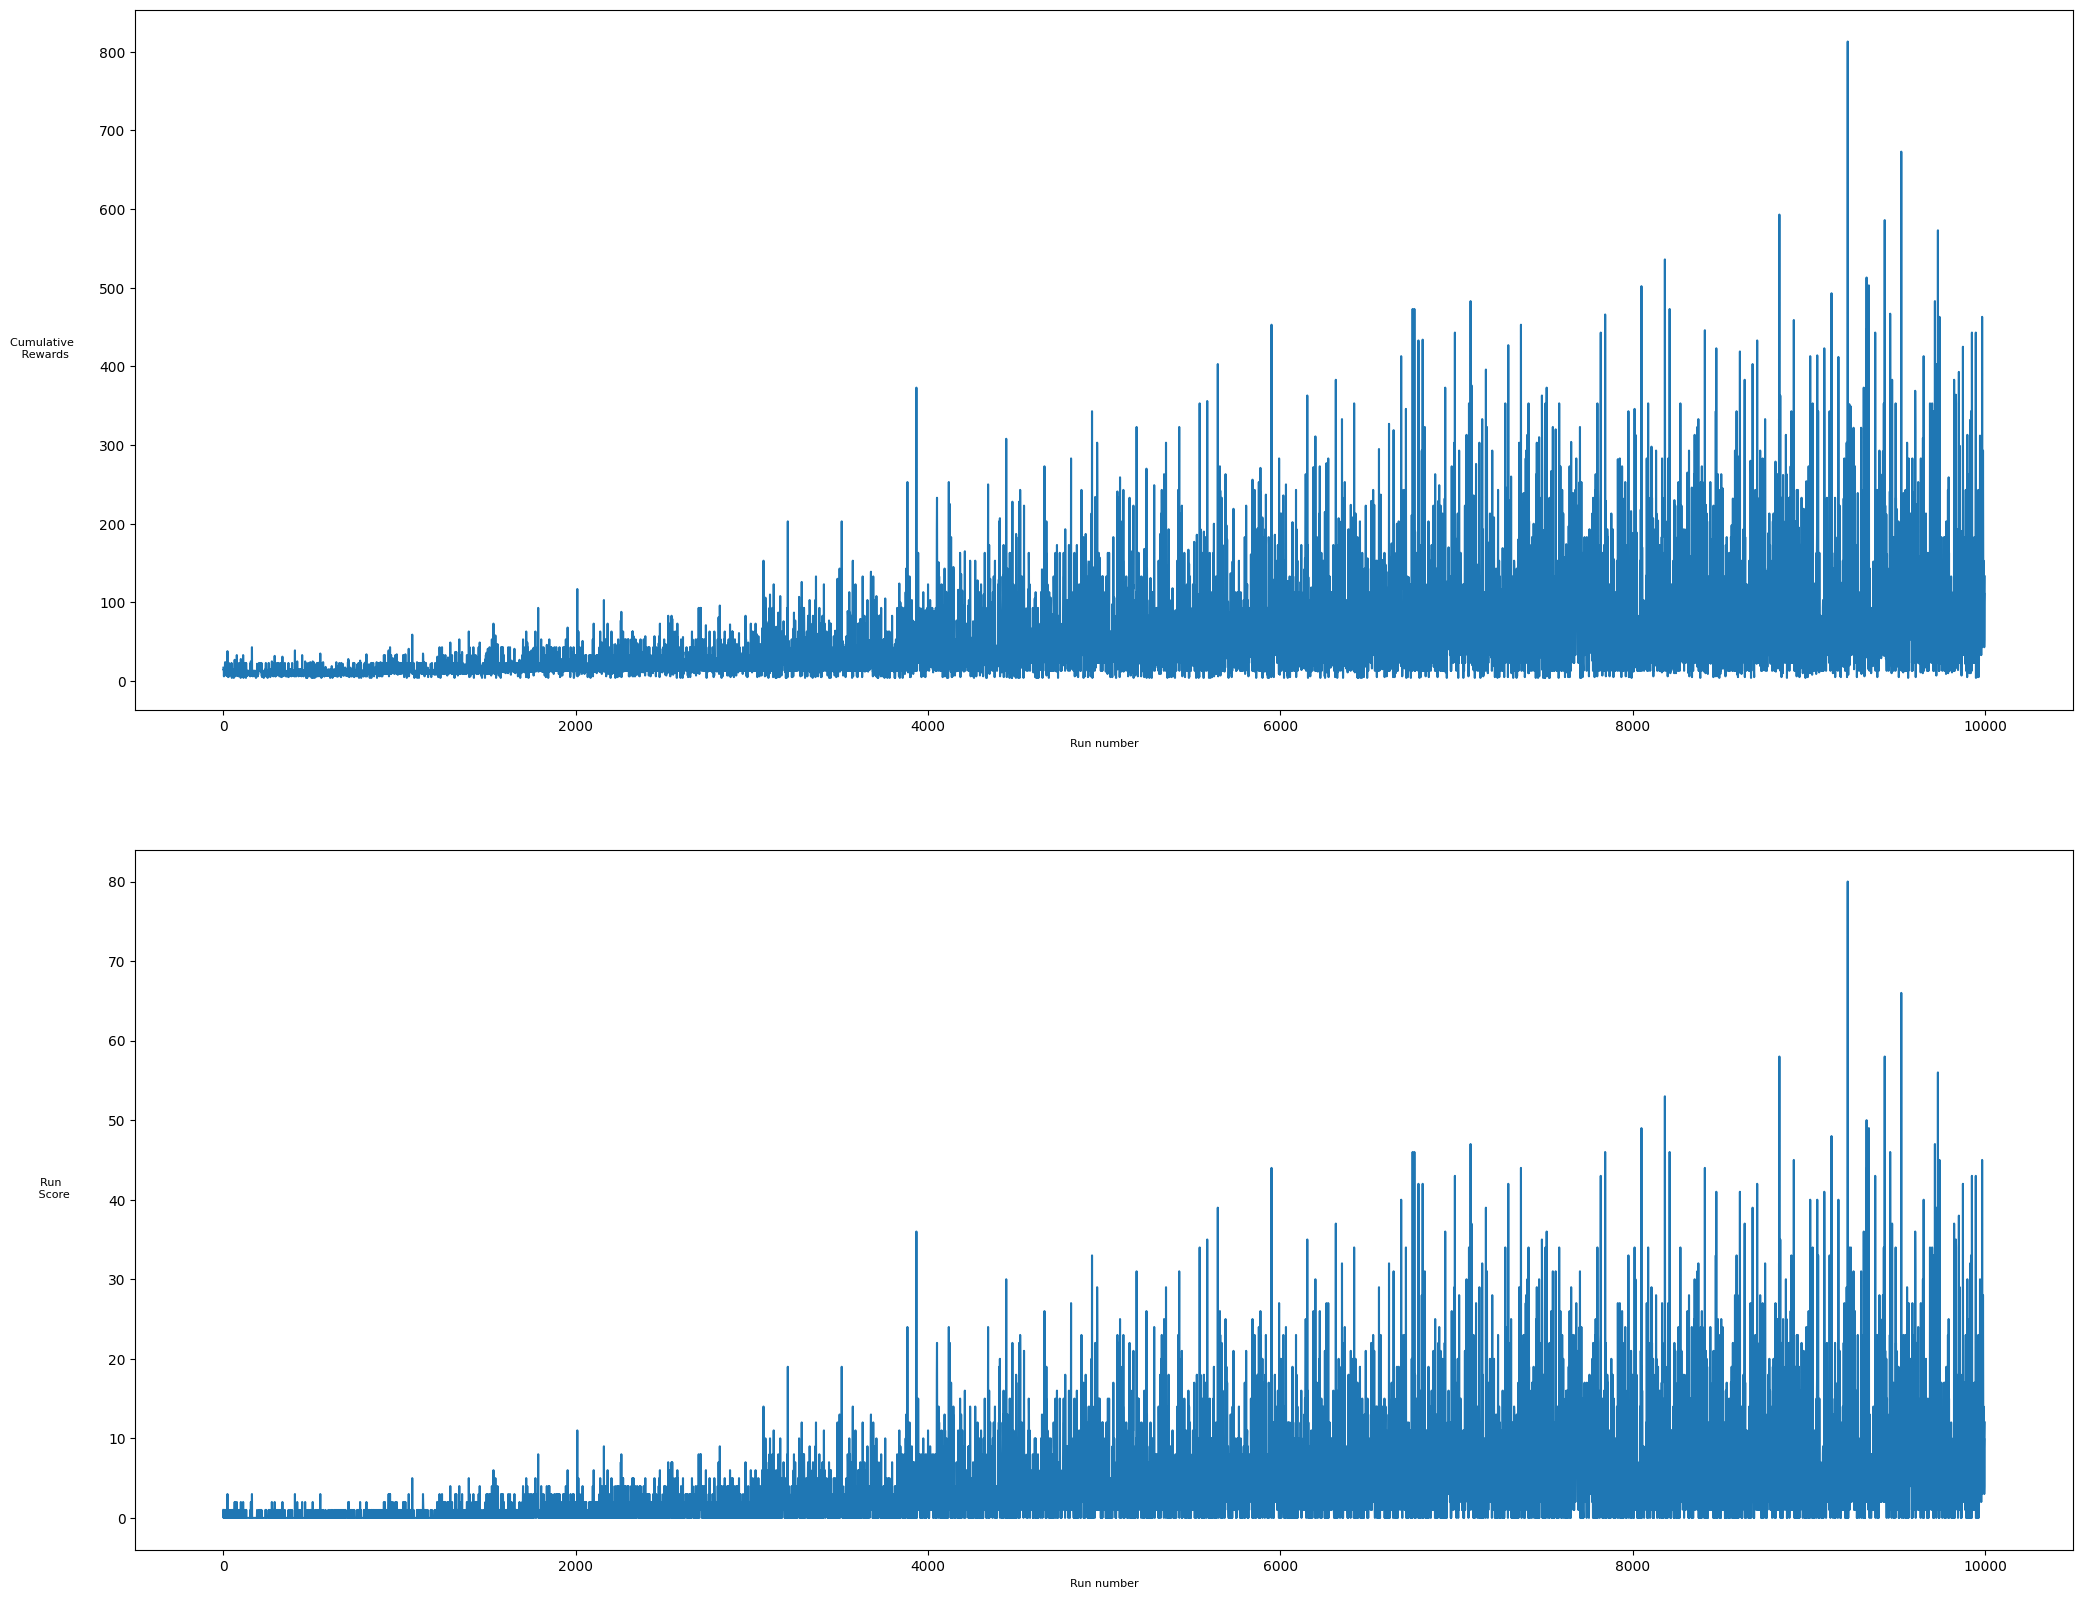

In [ ]:
#  Select agent
agent = SARSAAgent()

# Prepare run results arrays and agent initialization info
total_cumulative_rewards = [] # Cumalative rewards during episode
total_state_visits = [] # State visits counter
run_scores = [] # Run score
agent_info = {"num_actions": 2, "epsilon": 0.1, "eps_decay": 1, "step_size": 0.1, "step_size_decay": 1, "discount": 1, "seed": 42}
agent.agent_init(agent_info)

env_info = {}
num_runs = 10000 # The number of runs
num_episodes = 500 # The number of episodes in each run

# Iteration over the number of runs
for run in tqdm(range(num_runs)):

    # Set the seed value to the current run index x initial seed
    agent_info["seed"] = run*42

    # Initialize the environment
    state = env.reset()

    # Set done to False and 
    done = False

    cumulative_rewards = []
    state_visits = {}

    # Iterate over the number of episodes
    for episode in range(num_episodes):
        if episode == 0:
            # Reset environment and get state
            state, info = env.reset()
            # Start agent
            action = agent.agent_start(state)
            # Initialize state visits counter
            state_visits[state] = 1
            # Take step
            state, reward, done, _, info = env.step(action)
            cumulative_rewards.append(reward)
        else:
            while not done:
              # Select action
              action = agent.agent_step(reward, state)
              # Epsilon decay
              agent.epsilon = agent.epsilon * agent.eps_decay
              # Increment state visits counter
              if state not in state_visits: 
                  state_visits[state] = 1
              else:
                  state_visits[state] += 1
              # Take step
              state, reward, done, _, info = env.step(action)
              cumulative_rewards.append(reward)
              # If terminal state, end agent
              if done:
                action = agent.agent_end(reward)
                break

    # Update run results arrays
    total_cumulative_rewards.append(np.sum(cumulative_rewards))
    total_state_visits.append(state_visits)
    run_scores.append(info["score"])

# Plot the results
x = np.arange(num_runs)
plt.figure(figsize=(25, 20))
plt.subplot(211)
plt.plot(x, total_cumulative_rewards)
plt.xlabel("Run number")
plt.ylabel("Cumulative \n Rewards", rotation=0, labelpad=40)
plt.subplot(212)
plt.plot(x, run_scores)
plt.xlabel("Run number")
plt.ylabel("Run \n Score", rotation=0, labelpad=40)
plt.show()

#### c) Hyperparameter Tuning

Step-size Tuning:

In [ ]:
# Running grid search on step_size
labels = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"]
step_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

grid_scores = []
grid_rewards = []

for step_size in tqdm(step_sizes):
    # Prepare run results arrays and agent initialization info
    total_cumulative_rewards = [] # Cumalative rewards during episode
    total_state_visits = [] # State visits counter
    run_scores = [] # Run score
    agent_info = {"num_actions": 2, "epsilon": 0.1, "eps_decay": 1, "step_size": step_size, "step_size_decay": 1, "discount": 1, "seed": 42}
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index x initial seed
        agent_info["seed"] = run*42

        # Initialize the environment
        state = env.reset()

        # Set done to False and 
        done = False

        cumulative_rewards = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
                # Reset environment and get state
                state, info = env.reset()
                # Start agent
                action = agent.agent_start(state)
                # Initialize state visits counter
                state_visits[state] = 1
                # Take step
                state, reward, done, _, info = env.step(action)
                cumulative_rewards.append(reward)
            else:
                while not done:
                  # Select action
                  action = agent.agent_step(reward, state)
                  # Epsilon decay
                  agent.epsilon = agent.epsilon * agent.eps_decay
                  # Increment state visits counter
                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1
                  # Take step
                  state, reward, done, _, info = env.step(action)
                  cumulative_rewards.append(reward)
                  # If terminal state, end agent
                  if done:
                    action = agent.agent_end(reward)
                    break

        # Update run results arrays
        total_cumulative_rewards.append(np.sum(cumulative_rewards))
        total_state_visits.append(state_visits)
        run_scores.append(info["score"])

    grid_scores.append(run_scores)
    grid_rewards.append(total_cumulative_rewards)

100%|██████████| 9/9 [17:33<00:00, 117.06s/it]


In [ ]:
# Display results table
score_df = pd.DataFrame()
score_df["Step Size"] = [i for i in labels]
score_df["Mean Score"] = [np.mean(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Median Score"] = [np.median(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Max Score"] = [np.max(grid_scores[i]) for i in range(len(grid_scores))]

reward_df = pd.DataFrame()
reward_df["Step Size"] = [i for i in labels]
reward_df["Mean Reward"] = [np.mean(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Median Reward"] = [np.median(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Max Reward"] = [np.max(grid_rewards[i]) for i in range(len(grid_rewards))]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

Step Size  Mean Score  Median Score  Max Score
      0.1      5.6791           2.0        108
      0.2      7.5653           4.0         86
      0.3      9.0149           6.0        120
      0.4      8.5016           5.0        109
      0.5      8.9414           6.0        115
      0.6      8.1069           5.0         86
      0.7      7.6757           5.0         96
      0.8      6.8711           4.0         84
      0.9      6.2153           4.0         73
Step Size  Mean Reward  Median Reward  Max Reward
      0.1      68.0379           34.0        1093
      0.2      87.3233           53.0         873
      0.3     102.0338           68.0        1211
      0.4      96.7508           63.0        1103
      0.5     101.2706           71.0        1163
      0.6      92.8900           63.0         869
      0.7      88.4137           63.0         967
      0.8      80.3365           53.0         852
      0.9      73.7190           53.0         743


The grid search results seem to indicate that step-size impact on SARSA's performance is distributed as a bell shape around 0.5, with highest median and mean score/reward reached for 0.5. Step-size has an impact on convergence speed so we might have gotten other results with a different number of episodes per run.

Epsilon Tuning:

In [ ]:
# Running grid search on epsilon
labels = ["0.001", "0.005", "0.010", "0.015", "0.025", "0.050", "0.100", "0.150", "0.200"]
epsilons = [0.001, 0.005, 0.010, 0.015, 0.025, 0.050, 0.100, 0.150, 0.200]

grid_scores = []
grid_rewards = []

for epsilon in tqdm(epsilons):
    # Prepare run results arrays and agent initialization info
    total_cumulative_rewards = [] # Cumalative rewards during episode
    total_state_visits = [] # State visits counter
    run_scores = [] # Run score
    agent_info = {"num_actions": 2, "epsilon": epsilon, "eps_decay": 1, "step_size": 0.5, "step_size_decay": 1, "discount": 1, "seed": 42}
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index x initial seed
        agent_info["seed"] = run*42

        # Initialize the environment
        state = env.reset()

        # Set done to False and 
        done = False

        cumulative_rewards = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
                # Reset environment and get state
                state, info = env.reset()
                # Start agent
                action = agent.agent_start(state)
                # Initialize state visits counter
                state_visits[state] = 1
                # Take step
                state, reward, done, _, info = env.step(action)
                cumulative_rewards.append(reward)
            else:
                while not done:
                  # Select action
                  action = agent.agent_step(reward, state)
                  # Epsilon decay
                  agent.epsilon = agent.epsilon * agent.eps_decay
                  # Increment state visits counter
                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1
                  # Take step
                  state, reward, done, _, info = env.step(action)
                  cumulative_rewards.append(reward)
                  # If terminal state, end agent
                  if done:
                    action = agent.agent_end(reward)
                    break

        # Update run results arrays
        total_cumulative_rewards.append(np.sum(cumulative_rewards))
        total_state_visits.append(state_visits)
        run_scores.append(info["score"])

    grid_scores.append(run_scores)
    grid_rewards.append(total_cumulative_rewards)

100%|██████████| 9/9 [32:38<00:00, 217.65s/it]


In [ ]:
# Display results table
score_df = pd.DataFrame()
score_df["Epsilon"] = [i for i in labels]
score_df["Mean Score"] = [np.mean(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Median Score"] = [np.median(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Max Score"] = [np.max(grid_scores[i]) for i in range(len(grid_scores))]

reward_df = pd.DataFrame()
reward_df["Epsilon"] = [i for i in labels]
reward_df["Mean Reward"] = [np.mean(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Median Reward"] = [np.median(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Max Reward"] = [np.max(grid_rewards[i]) for i in range(len(grid_rewards))]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

Epsilon  Mean Score  Median Score  Max Score
  0.001      0.0001           0.0          1
  0.005     37.0417           7.0        671
  0.010     16.2631           6.0        389
  0.015     17.7188           3.0        490
  0.025     31.9091          19.0        487
  0.050     15.7030          10.0        231
  0.100      8.8245           6.0         93
  0.150      5.5761           4.0         66
  0.200      3.9641           3.0         55
Epsilon  Mean Reward  Median Reward  Max Reward
  0.001      10.4444           11.0          23
  0.005     381.9519           79.0        6723
  0.010     173.9536           73.0        3903
  0.015     188.8044           43.0        4913
  0.025     330.6370          195.0        4883
  0.050     168.9943          108.0        2323
  0.100     100.0763           73.0         943
  0.150      67.7492           49.0         674
  0.200      51.5472           38.0         562


The grid search results seem to indicate that epsilon impact on SARSA's performance is peaking for low epsilon values, with highest mean and median score/reward reached for 0.025 and 0.05. A low epsilon value means the agent selects the greedy action most of the time. Let's pick 0.05 as SARSA is more efficient with exploration convergence-wise.

Discount Tuning:

In [8]:
# Running grid search on discount
labels = ["1", "0.99", "0.95", "0.90", "0.85", "0.80", "0.75", "0.70", "0.65"]
discounts = [1, 0.99, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65]

grid_scores = []
grid_rewards = []

for discount in tqdm(discounts):
    # Prepare run results arrays and agent initialization info
    total_cumulative_rewards = [] # Cumalative rewards during episode
    total_state_visits = [] # State visits counter
    run_scores = [] # Run score
    agent_info = {"num_actions": 2, "epsilon": 0.05, "eps_decay": 1, "step_size": 0.5, "step_size_decay": 1, "discount": discount, "seed": 42}
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index x initial seed
        agent_info["seed"] = run*42

        # Initialize the environment
        state = env.reset()

        # Set done to False and 
        done = False

        cumulative_rewards = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
                # Reset environment and get state
                state, info = env.reset()
                # Start agent
                action = agent.agent_start(state)
                # Initialize state visits counter
                state_visits[state] = 1
                # Take step
                state, reward, done, _, info = env.step(action)
                cumulative_rewards.append(reward)
            else:
                while not done:
                  # Select action
                  action = agent.agent_step(reward, state)
                  # Epsilon decay
                  agent.epsilon = agent.epsilon * agent.eps_decay
                  # Increment state visits counter
                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1
                  # Take step
                  state, reward, done, _, info = env.step(action)
                  cumulative_rewards.append(reward)
                  # If terminal state, end agent
                  if done:
                    action = agent.agent_end(reward)
                    break

        # Update run results arrays
        total_cumulative_rewards.append(np.sum(cumulative_rewards))
        total_state_visits.append(state_visits)
        run_scores.append(info["score"])

    grid_scores.append(run_scores)
    grid_rewards.append(total_cumulative_rewards)

100%|██████████| 9/9 [49:31<00:00, 330.16s/it]


In [9]:
# Display results table
score_df = pd.DataFrame()
score_df["Discount"] = [i for i in labels]
score_df["Mean Score"] = [np.mean(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Median Score"] = [np.median(grid_scores[i]) for i in range(len(grid_scores))]
score_df["Max Score"] = [np.max(grid_scores[i]) for i in range(len(grid_scores))]

reward_df = pd.DataFrame()
reward_df["Discount"] = [i for i in labels]
reward_df["Mean Reward"] = [np.mean(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Median Reward"] = [np.median(grid_rewards[i]) for i in range(len(grid_rewards))]
reward_df["Max Reward"] = [np.max(grid_rewards[i]) for i in range(len(grid_rewards))]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

Discount  Mean Score  Median Score  Max Score
       1     25.3415          14.0        276
    0.99     26.4523          14.0        423
    0.95     19.7814           6.0        404
    0.90     29.3274          14.0        375
    0.85     25.9838          14.0        353
    0.80     29.1104          16.0        346
    0.75     26.6573          14.0        412
    0.70     18.0437           6.0        376
    0.65     20.2125           9.0        253
Discount  Mean Reward  Median Reward  Max Reward
       1     265.0490          153.0        2773
    0.99     276.3752          153.0        4243
    0.95     209.6601           73.0        4054
    0.90     305.2439          151.0        3763
    0.85     271.8197          148.5        3543
    0.80     303.1922          173.0        3473
    0.75     278.5288          153.0        4133
    0.70     192.5039           72.0        3773
    0.65     214.2106          103.0        2543


The grid search results seem to indicate that epsilon impact on SARSA's performance is very unequally distributed with two peaks of highest mean and median score/reward reached at 1 and 0.70. A discount of 1 seems safer to ensure a bias towards the long-term objective of staying alive. A discount factor of 1 means the agent values equally present and future rewards.

#### d) Final Training

100%|██████████| 20000/20000 [51:24<00:00,  6.48it/s]


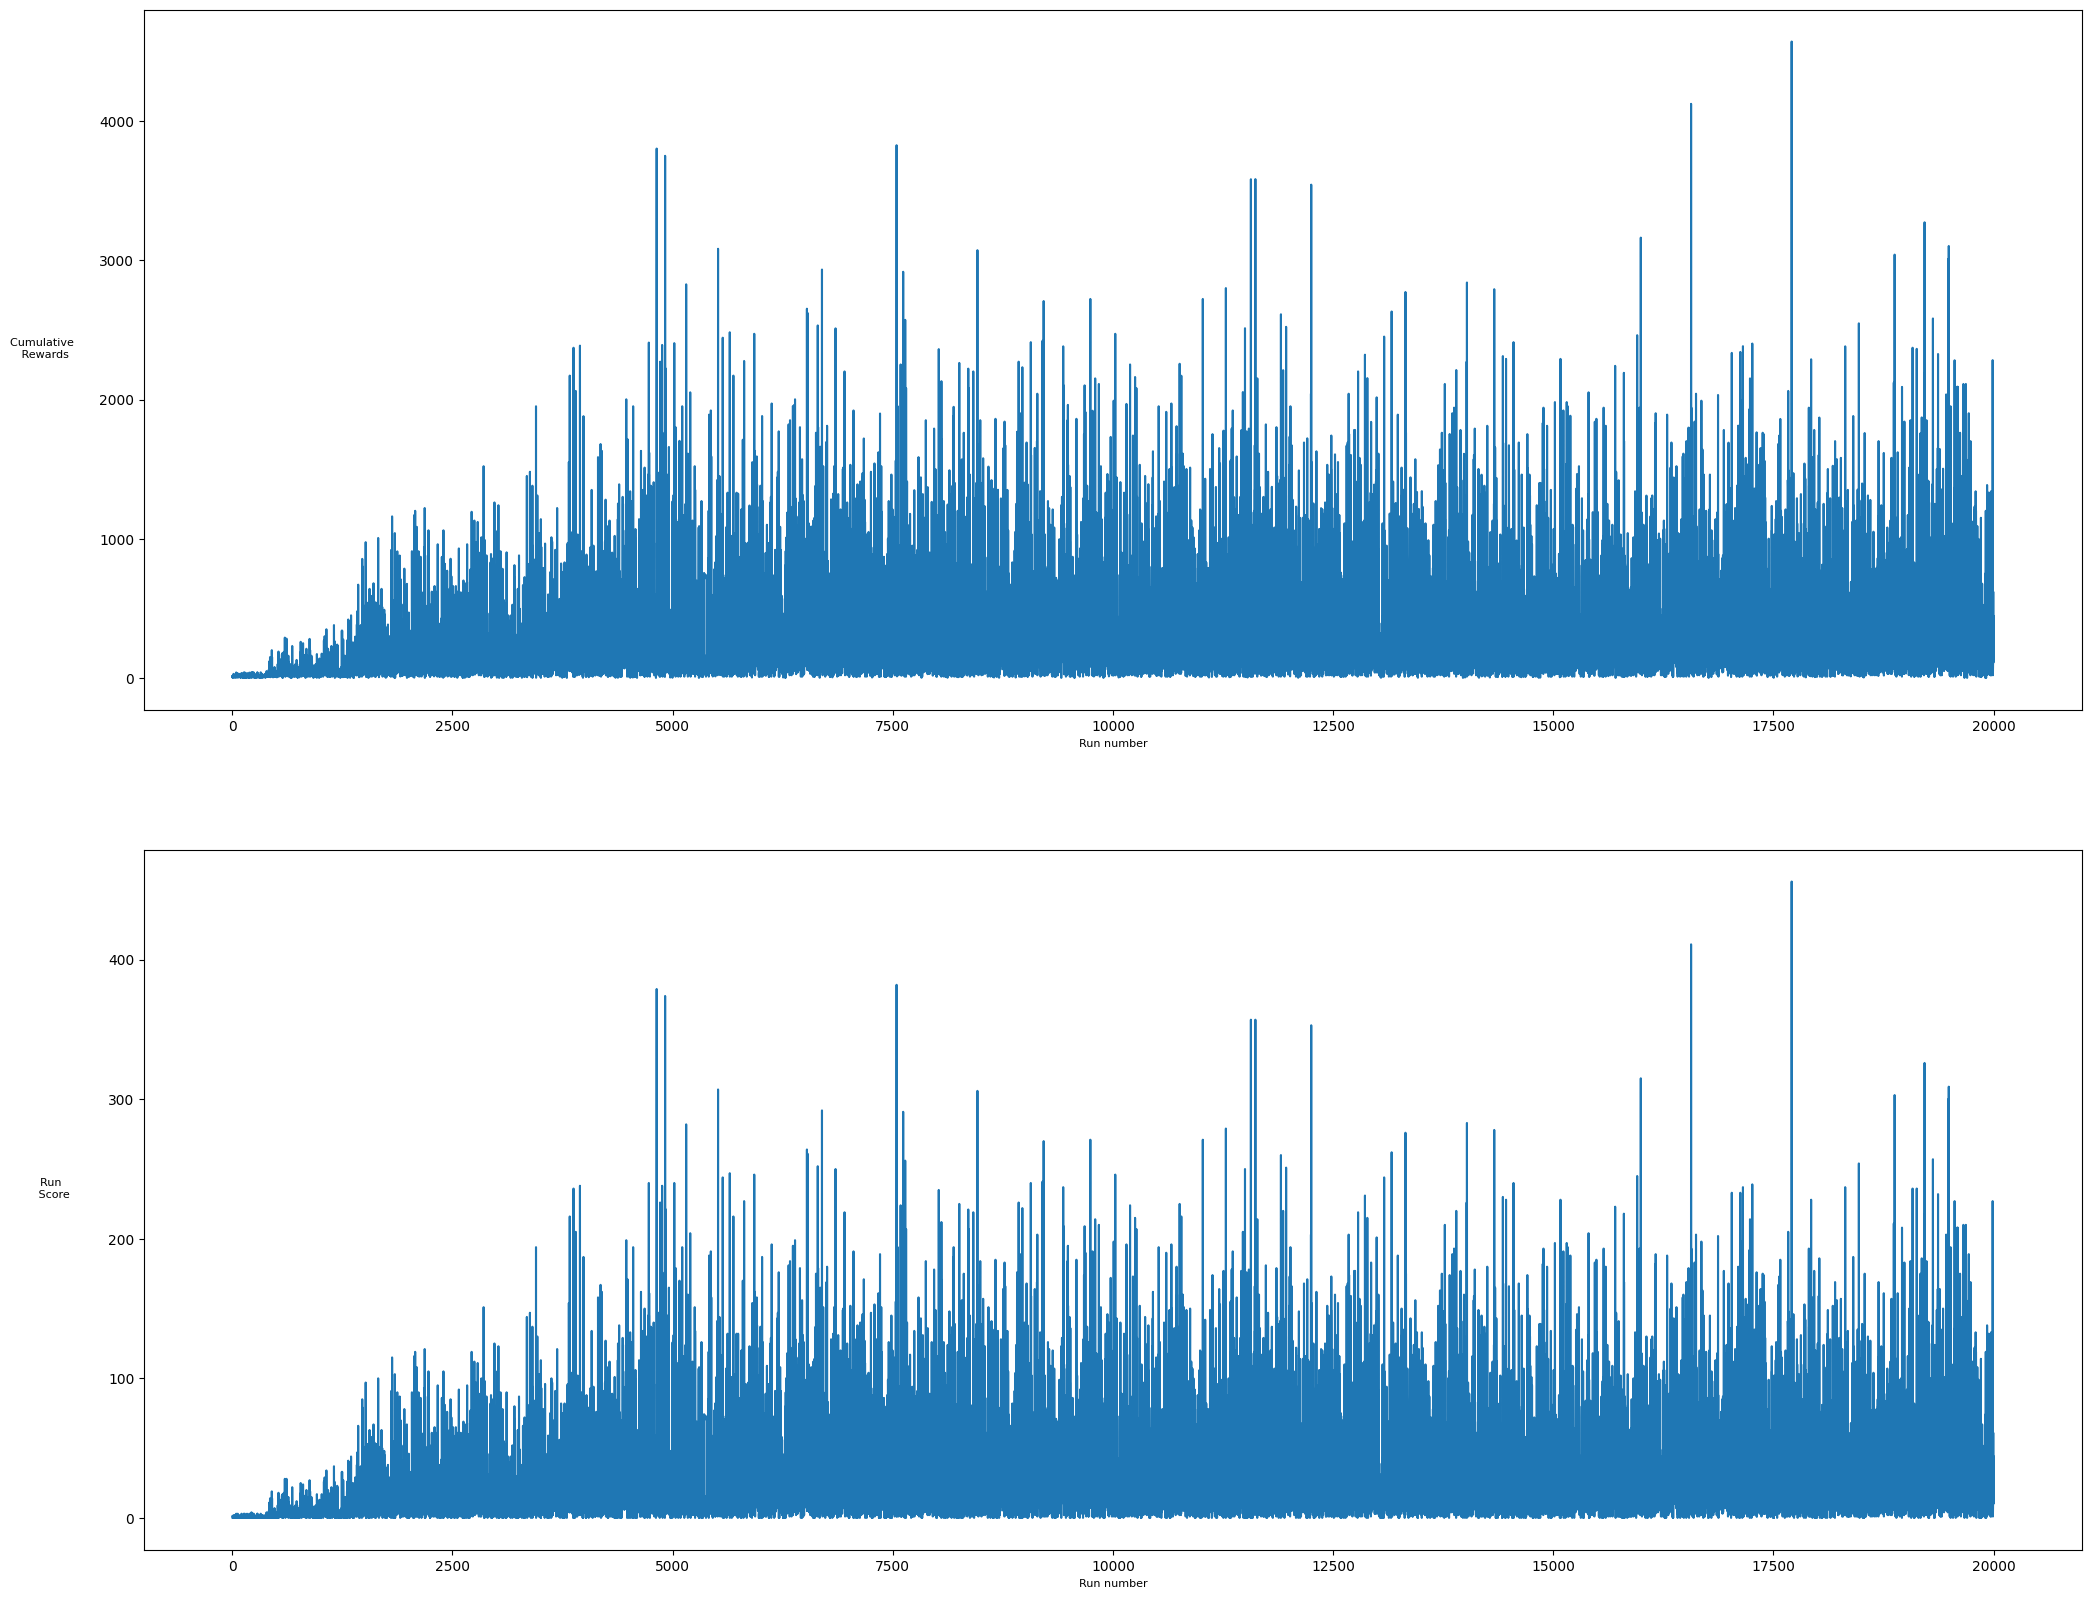

In [11]:
#  Select agent
agent = SARSAAgent()

# Prepare run results arrays and agent initialization info
total_cumulative_rewards = [] # Cumalative rewards during episode
total_state_visits = [] # State visits counter
run_scores = [] # Run score
agent_info = {"num_actions": 2, "epsilon": 0.05, "eps_decay": 1, "step_size": 0.5, "step_size_decay": 0.99, "discount": 1, "seed": 42}
agent.agent_init(agent_info)

env_info = {}
num_runs = 20000 # The number of runs
num_episodes = 1000000 # The number of episodes in each run

# Iteration over the number of runs
for run in tqdm(range(num_runs)):

    # Set the seed value to the current run index x initial seed
    agent_info["seed"] = run*42

    # Initialize the environment
    state = env.reset()

    # Set done to False and 
    done = False

    cumulative_rewards = []
    state_visits = {}

    # Iterate over the number of episodes
    for episode in range(num_episodes):
        if episode == 0:
            # Reset environment and get state
            state, info = env.reset()
            # Start agent
            action = agent.agent_start(state)
            # Initialize state visits counter
            state_visits[state] = 1
            # Take step
            state, reward, done, _, info = env.step(action)
            cumulative_rewards.append(reward)
        else:
            while not done:
              # Select action
              action = agent.agent_step(reward, state)
              # Epsilon decay
              agent.epsilon = agent.epsilon * agent.eps_decay
              # Increment state visits counter
              if state not in state_visits: 
                  state_visits[state] = 1
              else:
                  state_visits[state] += 1
              # Take step
              state, reward, done, _, info = env.step(action)
              cumulative_rewards.append(reward)
              # If terminal state, end agent
              if done:
                action = agent.agent_end(reward)
                break

    # Update run results arrays
    total_cumulative_rewards.append(np.sum(cumulative_rewards))
    total_state_visits.append(state_visits)
    run_scores.append(info["score"])

# Plot the results
x = np.arange(num_runs)
plt.figure(figsize=(25, 20))
plt.subplot(211)
plt.plot(x, total_cumulative_rewards)
plt.xlabel("Run number")
plt.ylabel("Cumulative \n Rewards", rotation=0, labelpad=40)
plt.subplot(212)
plt.plot(x, run_scores)
plt.xlabel("Run number")
plt.ylabel("Run \n Score", rotation=0, labelpad=40)
plt.show()

In [12]:
# Display results table
score_df = pd.DataFrame()
score_df["Mean Score"] = [np.mean(run_scores)]
score_df["Median Score"] = [np.median(run_scores)]
score_df["Max Score"] = [np.max(run_scores)]

reward_df = pd.DataFrame()
reward_df["Mean Reward"] = [np.mean(total_cumulative_rewards)]
reward_df["Median Reward"] = [np.median(total_cumulative_rewards)]
reward_df["Max Reward"] = [np.max(total_cumulative_rewards)]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

 Mean Score  Median Score  Max Score
    33.8059          21.0        456
 Mean Reward  Median Reward  Max Reward
   350.17025          223.0        4570


In [13]:
# Save Q-Table
with open('SARSA_qtable.pkl', 'wb') as f:
    pickle.dump(agent.q, f)

from google.colab import files
files.download('SARSA_qtable.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### e) Actual Run

In [89]:
# Load Q_table
q_table = pickle.load(open('SARSA_qtable.pkl', 'rb'))

# Prepare run results arrays
total_cumulative_rewards = [] # Cumalative rewards during episode
run_scores = [] # Run score

num_run = 3

for run in tqdm(range(num_run)):

    # Initialize the environment
    state, info = env.reset()
    cumulative_rewards = []

    done = False
    while not done:
        # Select the action with the highest Q-value in the current state
        x, y = state
        action = get_qvalue(x, y, q_table)
        
        if action == -1:
            # The current state has not been visited before, select a random action
            action = env.action_space.sample()
        
        # Take the selected action and observe the next state and reward, add reward to rewards
        state, reward, done, _, info = env.step(action)
        cumulative_rewards.append(reward)
        if info["score"] == 1000000:
            print("\n You are flapping those wings infinitely!!")
            break
    
    total_cumulative_rewards.append(np.sum(cumulative_rewards))
    run_scores.append(info["score"])

# Display results table
print('\n\n')
score_df = pd.DataFrame()
score_df["Mean Score"] = [np.mean(run_scores)]
score_df["Median Score"] = [np.median(run_scores)]
score_df["Max Score"] = [np.max(run_scores)]

reward_df = pd.DataFrame()
reward_df["Mean Reward"] = [np.mean(total_cumulative_rewards)]
reward_df["Median Reward"] = [np.median(total_cumulative_rewards)]
reward_df["Max Reward"] = [np.max(total_cumulative_rewards)]

print(score_df.to_string(index=False))
print(reward_df.to_string(index=False))

 33%|███▎      | 1/3 [02:21<04:42, 141.18s/it]


 You are flapping those wings infinitely!!


 67%|██████▋   | 2/3 [04:40<02:20, 140.04s/it]


 You are flapping those wings infinitely!!


100%|██████████| 3/3 [07:16<00:00, 145.52s/it]


 You are flapping those wings infinitely!!



 Mean Score  Median Score  Max Score
  1000000.0     1000000.0    1000000
 Mean Reward  Median Reward  Max Reward
  10000004.0     10000004.0    10000004


### 4. State-Value Functions

In [16]:
# Load final Q tables
QL_qtable = pickle.load(open('QLearning_qtable.pkl', 'rb'))
SA_qtable = pickle.load(open('SARSA_qtable.pkl', 'rb'))

Q-Learning Agent:

[Text(1, -1, 'NOT VISITED'), Text(1, 0, '0 (IDLE)'), Text(1, 1, '1 (FLAP)')]

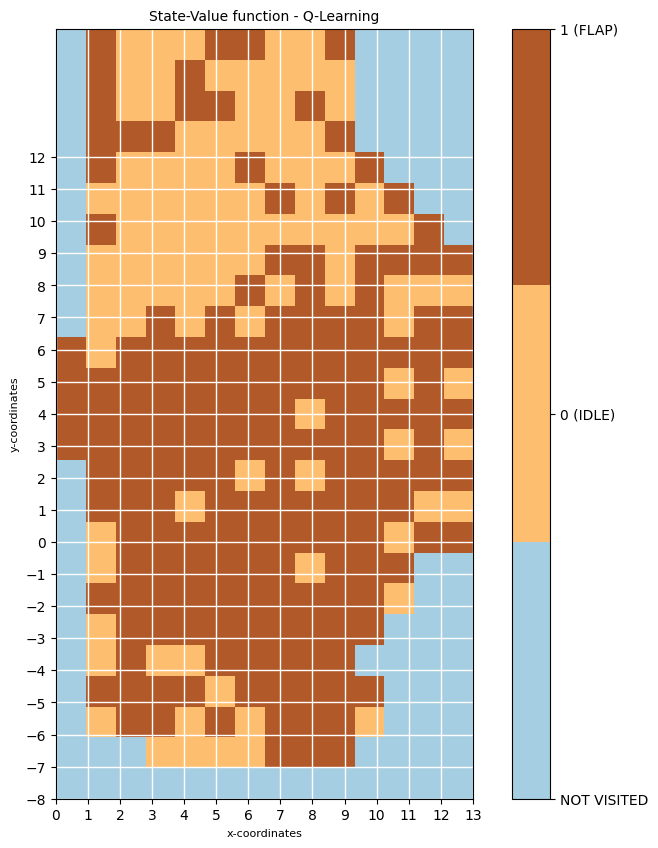

In [76]:
# Get the range of x/y-axis for the plot
x_values_QL = []
y_values_QL = []
QL_qtable.keys()

for key in QL_qtable.keys():
    
    x = key[0][0]
    y = key[0][1]
    
    if x not in x_values_QL:
        x_values_QL.append(x)
    
    if y not in y_values_QL:
        y_values_QL.append(y)
        
# Prepare the plot
x_range = sorted(x_values_QL)
y_range = sorted(y_values_QL)

X, Y = np.meshgrid(x_range, y_range)

Z = np.array([[get_qvalue(x, y, QL_qtable) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
surf = plt.imshow(Z, cmap=plt.get_cmap('Paired', 3), vmin=-1, vmax=1 , extent=[0, 13, -8, 16])
plt.title('State-Value function - Q-Learning', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(surf, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['NOT VISITED', '0 (IDLE)','1 (FLAP)'])

SARSA Agent:


[Text(1, -1, 'NOT VISITED'), Text(1, 0, '0 (IDLE)'), Text(1, 1, '1 (FLAP)')]

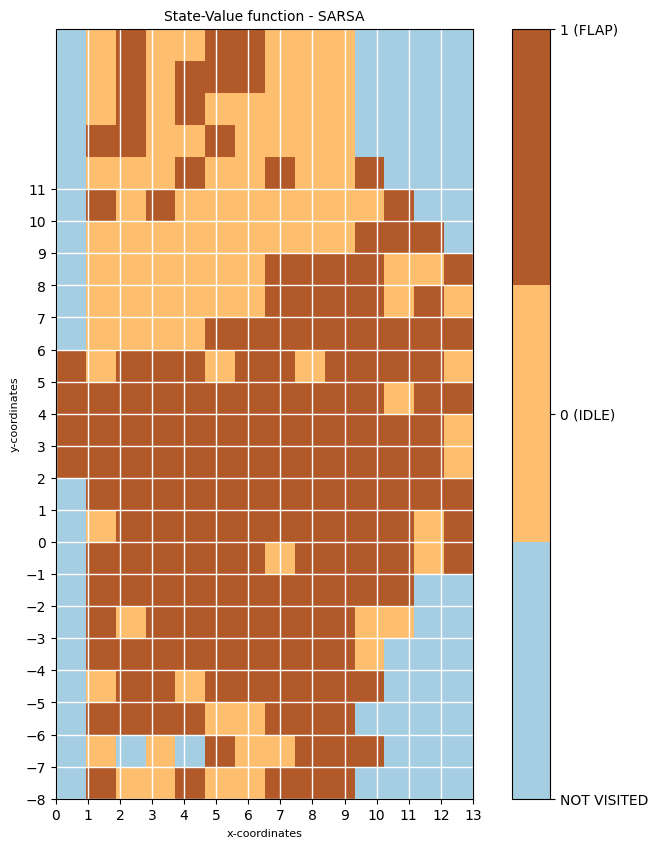

In [78]:
# Get the range of x/y-axis for the plot
x_values_QL = []
y_values_QL = []
SA_qtable.keys()

for key in SA_qtable.keys():
    
    x = key[0][0]
    y = key[0][1]
    
    if x not in x_values_QL:
        x_values_QL.append(x)
    
    if y not in y_values_QL:
        y_values_QL.append(y)
        
# Prepare the plot
x_range = sorted(x_values_QL)
y_range = sorted(y_values_QL)

X, Y = np.meshgrid(x_range, y_range)

Z = np.array([[get_qvalue(x, y, SA_qtable) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
surf = plt.imshow(Z, cmap=plt.get_cmap('Paired', 3), vmin=-1, vmax=1 , extent=[0, 13, -8, 16])
plt.title('State-Value function - SARSA', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(surf, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['NOT VISITED', '0 (IDLE)','1 (FLAP)'])